## Caso de Negocio

### Preparación de Ambiente

In [327]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.dates as mdates


### Cargar Dataframe

In [328]:
df = pd.read_csv('data/sales-drink.csv', encoding='latin-1')
df.columns = df.columns.str.lower()

In [329]:
print('Tamaño del dataset: ',df.shape)

Tamaño del dataset:  (52672, 15)


In [330]:
df.head(2)

,pedido,tienda,fecha,sabor,marca,segmento,segmento_desc,municipio,producto,producto_desc,unidades,monto,prom_temperatura,precio_unidad,contador
0,1000244507,1000043345,06-07-13,MANZANA,DEL VALLE,110,EXTRA GRANDE BAJO AUDITABLE,GUADALUPE,9322,JDV Manz Nec 100 m,24,48.0,31.9,2.0,1
1,1000242608,1000043345,02-07-13,MANGO,DEL VALLE,110,EXTRA GRANDE BAJO AUDITABLE,GUADALUPE,9321,JDV Mango Nec 100,24,48.0,26.5,2.0,1


### Limpieza y Transformación de Datos

In [331]:
df['monto_total'] = df['unidades']*df['monto']

df['fecha'] = pd.to_datetime(df['fecha'],format='%d-%m-%y')
df['fecha'] = df['fecha'].dt.strftime('%Y-%m-01')

In [332]:
dicc = {
    1000043345: 'Tienda 1',
    1000050643: 'Tienda 2',
    1000038155: 'Tienda 3',
    1000005887: 'Tienda 4',
    1000007403: 'Tienda 5',
    1000071011: 'Tienda 6'
}
df['tienda'] = df['tienda'].replace(dicc)

In [333]:
final_df = df.groupby(['tienda','fecha']).agg({
    'monto_total':'sum'
}
).sort_values(by=['tienda','fecha']).reset_index()

In [334]:
final_df

,tienda,fecha,monto_total
0,Tienda 1,2012-01-01,1610631.67
1,Tienda 1,2012-02-01,1591641.93
2,Tienda 1,2012-03-01,2533074.03
3,Tienda 1,2012-04-01,2738859.82
4,Tienda 1,2012-05-01,2879172.03
...,...,...,...
175,Tienda 6,2014-02-01,537247.74
176,Tienda 6,2014-03-01,291373.56
177,Tienda 6,2014-04-01,256601.44
178,Tienda 6,2014-05-01,432256.94


## ``ARIMA``


### Functions

In [335]:
def plot_acf_q(store):
    plot_acf(store['monto_total'])
    plt.title('ACF Plot')
    plt.show()

def plot_pacf_p(store):
    plot_pacf(store['monto_total'])
    plt.title('PACF Plot')
    plt.show()

In [336]:
def AIC(store):
# Comparar diferentes combinaciones de p, d, q
    aic_values = []
    for p in range(0, 3):  # Cambia el rango según sea necesario
        for d in range(0, 3):
            for q in range(0, 3):
                try:
                    model = ARIMA(store['monto_total'], order=(p, d, q))
                    model_fit = model.fit()
                    aic_values.append((p, d, q, model_fit.aic))
                except:
                    continue

    # Crear un DataFrame para visualizar los resultados
    aic_df = pd.DataFrame(aic_values, columns=['p', 'd', 'q', 'AIC'])
    sorted_aic_df = aic_df.sort_values('AIC').reset_index(drop=True)
    print(sorted_aic_df)
    p,d,q = sorted_aic_df.iloc[0,0:3].values
    return p,d,q

In [337]:
def arima_per_store(group,p=1,d=1,q=1):
    model = ARIMA(group, order=(p,d,q))  # Cambia los parámetros p, d, q si es necesario
    model_fit = model.fit()

    # Mostrar los resultados del resumen
    print(model_fit.summary())

    # Graficar el ajuste del modelo
    model_fit.plot_diagnostics(figsize=(10,8))
    plt.tight_layout()
    plt.show()

### Tienda 1

In [338]:
tienda_1 = final_df[final_df['tienda']=='Tienda 1']

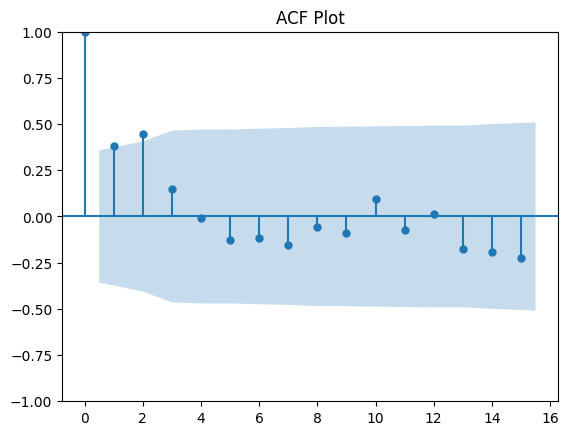

In [339]:
plot_acf_q(tienda_1)

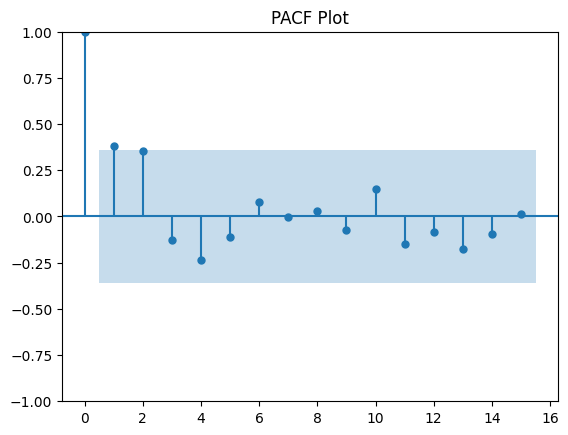

In [340]:
plot_pacf_p(tienda_1)

In [341]:
p,d,q = AIC(tienda_1)

g:\Supermarket-Sales-Tracker-Mx\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
g:\Supermarket-Sales-Tracker-Mx\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
g:\Supermarket-Sales-Tracker-Mx\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
g:\Supermarket-Sales-Tracker-Mx\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fou

    p  d  q         AIC
0   2  2  0  849.829892
1   1  2  1  850.686612
2   2  2  1  851.652366
3   1  2  2  853.076650
4   2  2  2  854.168754
5   1  2  0  856.359447
6   0  2  2  856.676978
7   0  2  1  862.927842
8   0  1  2  872.314062
9   1  1  2  873.934860
10  2  1  2  875.209168
11  1  1  0  875.379243
12  2  1  0  876.620032
13  1  1  1  877.021909
14  2  1  1  878.031285
15  0  1  1  879.092192
16  0  1  0  882.981387
17  0  2  0  884.446379
18  1  0  2  901.274609
19  2  0  2  902.806661
20  0  0  2  903.789202
21  2  0  0  905.099866
22  2  0  1  906.743504
23  1  0  0  907.414323
24  1  0  1  907.925780
25  0  0  1  909.939510
26  0  0  0  983.531000


                               SARIMAX Results                                
Dep. Variable:            monto_total   No. Observations:                   30
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -421.915
Date:                Mon, 14 Oct 2024   AIC                            849.830
Time:                        23:56:44   BIC                            853.827
Sample:                             0   HQIC                           851.052
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2442      0.174     -7.167      0.000      -1.584      -0.904
ar.L2         -0.5271      0.172     -3.065      0.002      -0.864      -0.190
sigma2       7.63e+11   6.46e-14   1.18e+25      0.0

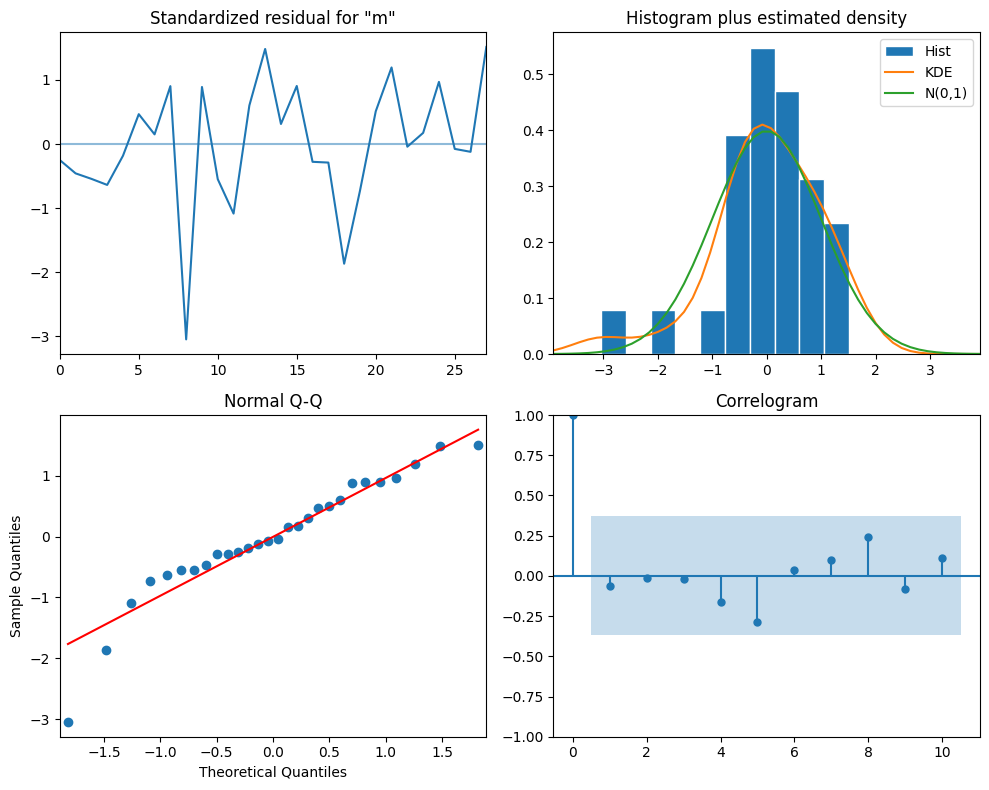

In [342]:
arima_per_store(tienda_1['monto_total'],p,d,q)

## ``Triple Exponential Smoothing``


### Functions

In [343]:
def Exponential_Smoothing(tienda):
    model = ExponentialSmoothing(tienda['monto_total'], 
                                trend='add', 
                                seasonal='add', 
                                seasonal_periods=12)  # Cambia a 4 si los datos son trimestrales
    model_fit = model.fit()
    # Mostrar el resumen del modelo
    print(model_fit.summary())
    return model_fit

In [344]:
def plot_predictions(model_fit,tienda):
    tienda = tienda.set_index(['fecha'])
    predictions = model_fit.forecast(steps=6)

    last_date = tienda.index[-1] 
    pred_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(months=1), periods=6, freq='MS')
    string_index = pd.Index(pred_dates.strftime('%Y-%m-%d'))

    plt.figure(figsize=(10, 6))
    plt.plot(tienda.index, tienda['monto_total'], label='Datos Observados', marker='o')
    plt.plot(string_index, predictions, label='Predicciones', marker='o', color='red')
    plt.xlim([tienda.index.min(), pred_dates.max().strftime('%Y-%m-%d')])

    all_dates = pd.date_range(start=tienda.index.min(), end=pred_dates.max().strftime('%Y-%m-%d'), freq='MS').strftime('%Y-%m-%d')
    half_xticks = all_dates[::2]
    plt.xticks(half_xticks, rotation=60)
    plt.title('Triple Exponential Smoothing - Holt-Winters para Tienda 1')
    plt.xlabel('Fecha')
    plt.ylabel('Monto Total')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [345]:
def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

In [346]:
def MAPE(model_fit,tienda):
    # Descomposición de componentes
    fitted_values = model_fit.fittedvalues
    trend = fitted_values - (tienda['monto_total'] - fitted_values)  # Componentes de tendencia

    # Calcular la estacionalidad
    seasonal = fitted_values - trend
    irregular = tienda['monto_total'] - fitted_values

    # Calcular MAPE
    mape = calculate_mape(tienda['monto_total'], fitted_values)
    print(f'MAPE: {mape:.2f}%')

    # Graficar componentes
    plt.figure(figsize=(12, 8))
    
    plt.subplot(4, 1, 1)
    plt.plot(tienda.index, trend, label='Tendencia', color='blue')
    plt.title('Tendencia')
    plt.legend()
    
    plt.subplot(4, 1, 2)
    plt.plot(tienda.index, seasonal, label='Estacionalidad', color='green')
    plt.title('Estacionalidad')
    plt.legend()
    
    plt.subplot(4, 1, 3)
    plt.plot(tienda.index, irregular, label='Componente Irregular', color='orange')
    plt.title('Componente Irregular')
    plt.legend()
    
    plt.subplot(4, 1, 4)
    plt.plot(tienda.index, tienda['monto_total'], label='Datos Observados', marker='o')
    plt.plot(tienda.index, fitted_values, label='Ajuste', marker='o', color='red')
    plt.title('Datos Observados y Ajuste')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### Tienda 1

In [347]:
tienda_1 = final_df[final_df['tienda']=='Tienda 1']

In [348]:
model_fit = Exponential_Smoothing(tienda_1)

                       ExponentialSmoothing Model Results                       
Dep. Variable:              monto_total   No. Observations:                   30
Model:             ExponentialSmoothing   SSE                 15757097209204.422
Optimized:                         True   AIC                            841.613
Trend:                         Additive   BIC                            864.033
Seasonal:                      Additive   AICC                           903.795
Seasonal Periods:                    12   Date:                 Mon, 14 Oct 2024
Box-Cox:                          False   Time:                         23:56:45
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4646429                alpha                 True
smoothing_trend          

g:\Supermarket-Sales-Tracker-Mx\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


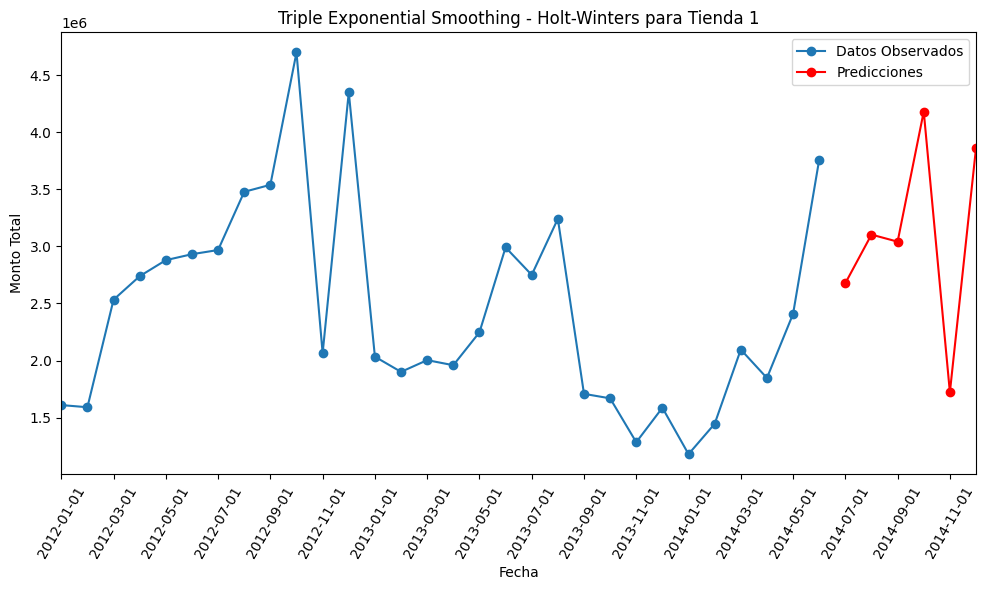

In [349]:
plot_predictions(model_fit,tienda_1)

MAPE: 28.37%


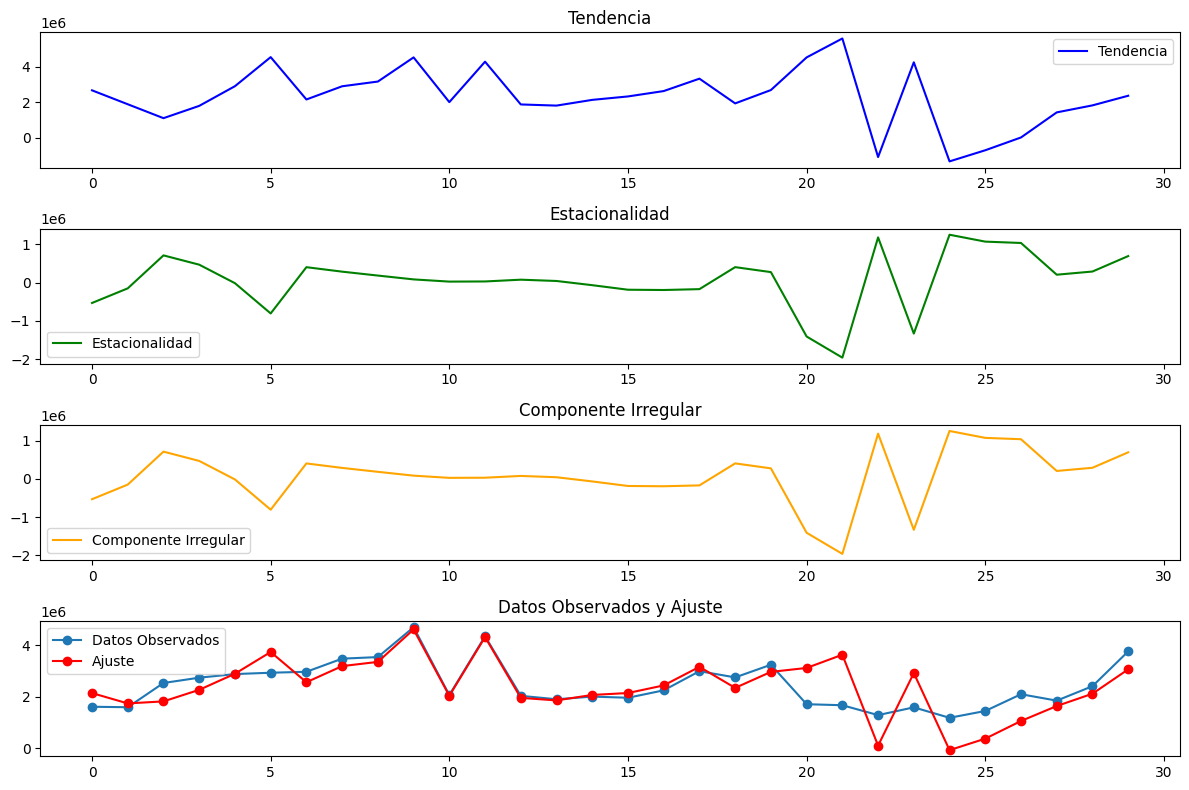

In [350]:
MAPE(model_fit,tienda_1)

# Evaluación de resultados

# Conclusiones